In [1]:
# encoding=utf8
import sys

# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import re
from afinn import Afinn

reload(sys)
sys.setdefaultencoding('utf8')

%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Entrenamieto_ECI_2020.csv')
data.head()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Delivery_Quarter,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A
0,27761,EMEA,None,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,...,Q2,2016,NaT,10,EUR,"5,272,800.00",EUR,"5,272,800.00",Closed Lost,Prod_Category_A_None
1,27760,EMEA,None,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,...,Q1,2016,NaT,0,EUR,"48,230.00",EUR,"48,230.00",Closed Won,Prod_Category_A_None
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,...,Q1,2016,NaT,0,USD,"83,865.60",USD,"83,865.60",Closed Won,Prod_Category_A_None
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,Q1,2018,NaT,14,USD,"7,421,881.50",USD,"7,421,881.50",Closed Lost,Prod_Category_A_None
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,Q1,2018,NaT,25,USD,"13,357,192.50",USD,"13,357,192.50",Closed Lost,Prod_Category_A_None


In [3]:
data.shape

(16947, 52)

In [4]:
data.size

881244

In [5]:
data.count()

ID                                    16947
Region                                16947
Territory                             16947
Pricing, Delivery_Terms_Quote_Appr    16947
Pricing, Delivery_Terms_Approved      16947
Bureaucratic_Code_0_Approval          16947
Bureaucratic_Code_0_Approved          16947
Submitted_for_Approval                16947
Bureaucratic_Code                     16947
Account_Created_Date                  16947
Source                                16947
Billing_Country                       16947
Account_Name                          16947
Opportunity_Name                      16947
Opportunity_ID                        16947
Sales_Contract_No                     16947
Account_Owner                         16947
Opportunity_Owner                     16947
Account_Type                          16947
Opportunity_Type                      16947
Quote_Type                            16947
Delivery_Terms                        16947
Opportunity_Created_Date        

In [6]:
data_by_region = data.groupby(['Region','Stage']).size().reset_index(name='count')
data_by_region
#repeated = data_by_region[data_by_region['count']>1].sort_values(by='count', ascending=False)
#repeated[repeated.target==1].describe()

,Region,Stage,count
0,APAC,Closed Lost,1355
1,APAC,Closed Won,1896
2,APAC,Proposal,8
3,APAC,Qualification,3
4,Americas,Closed Lost,2140
5,Americas,Closed Won,1793
6,Americas,Negotiation,8
7,Americas,Proposal,4
8,EMEA,Closed Lost,2189
9,EMEA,Closed Won,2471


In [7]:
data['Total_Taxable_Amount_Currency'].unique()

array(['EUR', 'USD', 'JPY', 'AUD', 'GBP'], dtype=object)

In [8]:
data['Total_Amount'] = data['Total_Amount'].fillna(0)
data[data['Total_Amount'].isnull()]['Total_Amount']

Series([], Name: Total_Amount, dtype: float64)

In [9]:
#data['Total_Amount'] = data['Total_Amount'].fillna(0)
data[data['Total_Taxable_Amount'].isnull()]['Total_Taxable_Amount']

Series([], Name: Total_Taxable_Amount, dtype: float64)

In [10]:
pd.to_datetime(data['Month']).dt.year.unique()

array([2016, 2018, 2017, 2019, 2020], dtype=int64)

In [11]:
#data['Total_Amount_Currency'] = data['Total_Amount_Currency'].astype(str)
#data['Total_Amount_Currency'].map(lambda x:  type(x))

In [12]:
# https://data.oecd.org/conversion/exchange-rates.htm
price_usd_convertion_by_year = {
    'EUR': {2016: 0.940, 2017: 0.923, 2018: 0.848, 2019: 0.893, 2020: 0.860},
    'JPY': {2016: 113.138, 2017: 116.667, 2018: 110.424, 2019: 109.008, 2020: 104.66},
    'AUD': {2016: 1.400, 2017: 1.358, 2018: 1.340, 2019: 1.439, 2020: 1.420},
    'GBP': {2016: 0.770, 2017: 0.808, 2018: 0.750, 2019: 0.784, 2020: 0.770},
    'USD': {2016: 1, 2017: 1, 2018: 1, 2019: 1, 2020: 1}
}

def get_convertion_usd(x):
    currency = x['Total_Amount_Currency']
    year = pd.to_datetime(x['Month']).year
    return price_usd_convertion_by_year[currency][year]
    
data['Total_Amount_USD'] = data['Total_Amount'] / data.apply(lambda x: get_convertion_usd(x), axis=1)

data['Total_Amount_USD'].head()

0           5,609,361.70
1              51,308.51
2              83,865.60
3           7,421,881.50
4          13,357,192.50
Name: Total_Amount_USD, dtype: float64

In [13]:
data['Total_Amount_USD'].describe()

count              16,947.00
mean              990,804.94
std             5,772,734.01
min                     0.00
25%                 4,107.18
50%                77,910.00
75%               281,702.63
max           315,000,081.90
Name: Total_Amount_USD, dtype: float64

Text(0,0.5,'Densidad')

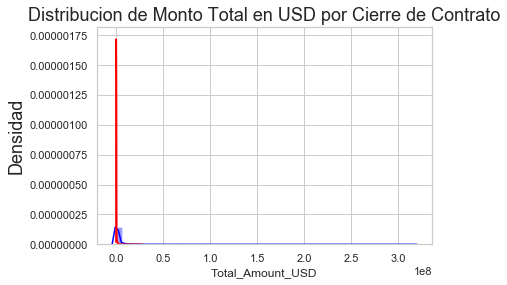

In [14]:
g = sns.distplot(data[data['Stage'] == "Closed Lost"]['Total_Amount_USD'], color="blue", label='Closed Lost', hist=True)
g = sns.distplot(data[data['Stage'] == "Closed Won"]['Total_Amount_USD'], color="red", label='Closed Won', hist=True)
g.set_title("Distribucion de Monto Total en USD por Cierre de Contrato", fontsize=18)
g.set_ylabel("Densidad", fontsize=18)

In [15]:
closed_contracts = data[ (data['Stage'] == "Closed Lost") | (data['Stage'] == "Closed Won") ]

In [16]:
closed_contracts.shape

(16883, 53)

Text(0,0.5,'Total_Amount_USD')

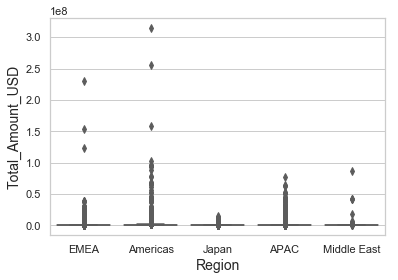

In [17]:
g = sns.boxplot(x="Region", y="Total_Amount_USD", 
                     data=closed_contracts, palette="hls")
g.set_title("", fontsize=18)
g.set_xlabel("Region", fontsize=14)
g.set_ylabel("Total_Amount_USD", fontsize=14)

In [18]:
data_by_region = data.groupby(['Region','Stage']).size()
data_by_region = data_by_region.unstack().reset_index().fillna(0)
data_by_region

Stage,Region,Closed Lost,Closed Won,Negotiation,Proposal,Qualification
0,APAC,"1,355.00","1,896.00",0.00,8.00,3.00
1,Americas,"2,140.00","1,793.00",8.00,4.00,0.00
2,EMEA,"2,189.00","2,471.00",1.00,3.00,0.00
3,Japan,"1,546.00","3,323.00",1.00,14.00,8.00
4,Middle East,120.00,50.00,8.00,6.00,0.00


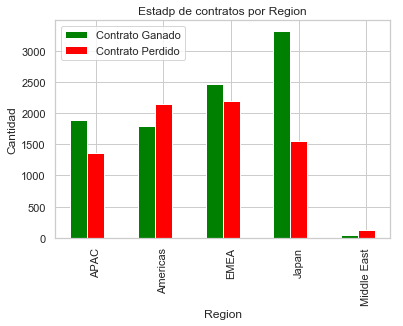

In [19]:
# bar graphs
fig, ax = plt.subplots()
x = np.arange(data_by_region.shape[0])
width = 0.25

c_won = data_by_region["Closed Won"].to_numpy()
c_lost = data_by_region["Closed Lost"].to_numpy()

ax.bar(x, c_won, width, color='green', label='Contrato Ganado')
ax.bar(x + width, c_lost , width, color='red', label='Contrato Perdido')
ax.set_xticks(x + width)
ax.set_xticklabels(data_by_region['Region'], rotation='vertical')
plt.title("Estadp de contratos por Region")
plt.xlabel("Region")
plt.ylabel("Cantidad")
ax.legend()
plt.show()

In [20]:
data.loc[data['Territory'] == 'None', 'Territory'] = data['Billing_Country']
data[data['Territory'] == 'None']['Territory'].head()

3063     None
16144    None
Name: Territory, dtype: object

In [21]:
parsed_territories = data.loc[data['Territory'] != 'None', :]
parsed_territories.head()

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Total_Amount_USD
0,27761,EMEA,Netherlands,1,1,1,1,0,Bureaucratic_Code_4,6/16/2015,...,2016,NaT,10,EUR,"5,272,800.00",EUR,"5,272,800.00",Closed Lost,Prod_Category_A_None,"5,609,361.70"
1,27760,EMEA,Netherlands,0,0,0,0,0,Bureaucratic_Code_4,6/16/2015,...,2016,NaT,0,EUR,"48,230.00",EUR,"48,230.00",Closed Won,Prod_Category_A_None,"51,308.51"
2,27446,Americas,NW America,0,0,0,0,0,Bureaucratic_Code_4,4/21/2015,...,2016,NaT,0,USD,"83,865.60",USD,"83,865.60",Closed Won,Prod_Category_A_None,"83,865.60"
3,16808,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,2018,NaT,14,USD,"7,421,881.50",USD,"7,421,881.50",Closed Lost,Prod_Category_A_None,"7,421,881.50"
4,16805,Americas,NW America,1,0,1,0,0,Bureaucratic_Code_5,7/27/2013,...,2018,NaT,25,USD,"13,357,192.50",USD,"13,357,192.50",Closed Lost,Prod_Category_A_None,"13,357,192.50"


In [22]:
territories_count = parsed_territories.groupby(['Territory', 'Stage'])['ID'].count()
territories_unstacked = territories_count.unstack().reset_index().rename(columns={"ID": "count"}).fillna(0)
#territories_count = parsed_territories.groupby(['Territory', 'Stage'])['ID'].agg({'count'})
#territories_unstacked = territories_count.unstack().fillna(0)
#territories_unstacked.columns = territories_unstacked.columns.droplevel()
territories_unstacked.columns.name = ""
territories_unstacked.head()

,Territory,Closed Lost,Closed Won,Negotiation,Proposal,Qualification
0,Albania,3.00,0.00,0.00,0.00,0.00
1,Armenia,2.00,0.00,0.00,0.00,0.00
2,Australia,506.00,696.00,0.00,4.00,2.00
3,Austria,21.00,124.00,0.00,0.00,0.00
4,Belarus,4.00,0.00,0.00,0.00,0.00


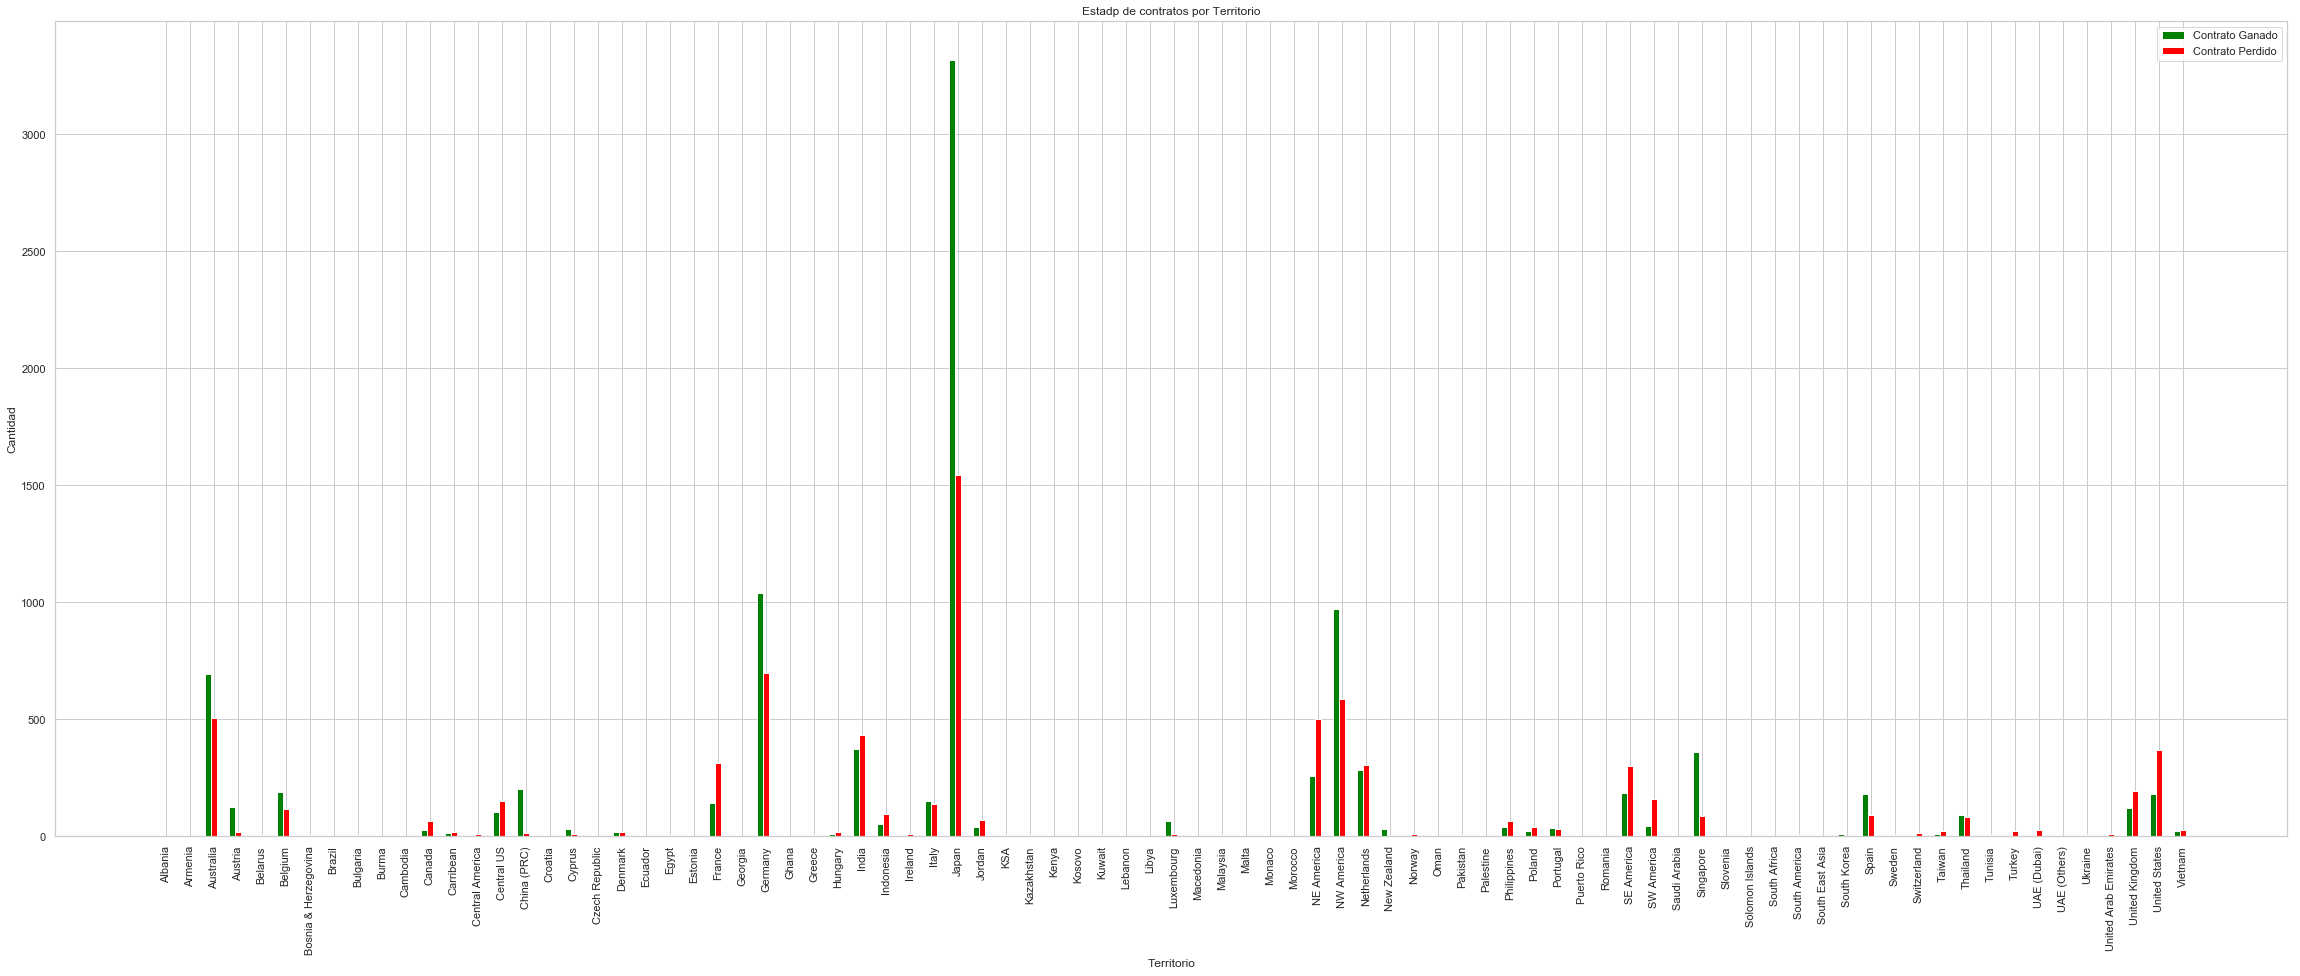

In [27]:
# bar graphs
fig, ax = plt.subplots()
x = np.arange(territories_unstacked.shape[0])
width = 0.25

c_won = territories_unstacked["Closed Won"].to_numpy()
c_lost = territories_unstacked["Closed Lost"].to_numpy()

ax.bar(x, c_won, width, color='green', label='Contrato Ganado')
ax.bar(x + width, c_lost , width, color='red', label='Contrato Perdido')
ax.set_xticks(x + width)
ax.set_xticklabels(territories_unstacked['Territory'], rotation='vertical')
plt.title("Estadp de contratos por Territorio")
plt.xlabel("Territorio")
plt.ylabel("Cantidad")
ax.legend()
plt.rcParams['figure.figsize'] = [40, 15]
plt.show()

In [24]:
territories_unstacked['Closed'] = territories_unstacked['Closed Won'] + territories_unstacked['Closed Lost']
territories_unstacked.head()

,Territory,Closed Lost,Closed Won,Negotiation,Proposal,Qualification,Closed
0,Albania,3.00,0.00,0.00,0.00,0.00,3.00
1,Armenia,2.00,0.00,0.00,0.00,0.00,2.00
2,Australia,506.00,696.00,0.00,4.00,2.00,"1,202.00"
3,Austria,21.00,124.00,0.00,0.00,0.00,145.00
4,Belarus,4.00,0.00,0.00,0.00,0.00,4.00


In [25]:
territories_gt_100_contracts = territories_unstacked[territories_unstacked['Closed'] >= 100].sort_values(by=['Closed'], ascending=False)
territories_gt_100_contracts.head()

,Territory,Closed Lost,Closed Won,Negotiation,Proposal,Qualification,Closed
33,Japan,"1,543.00","3,319.00",1.00,14.00,8.00,"4,862.00"
25,Germany,698.00,"1,040.00",0.00,0.00,0.00,"1,738.00"
49,NW America,587.00,973.00,8.00,0.00,0.00,"1,560.00"
2,Australia,506.00,696.00,0.00,4.00,2.00,"1,202.00"
29,India,434.00,374.00,0.00,1.00,1.00,808.00


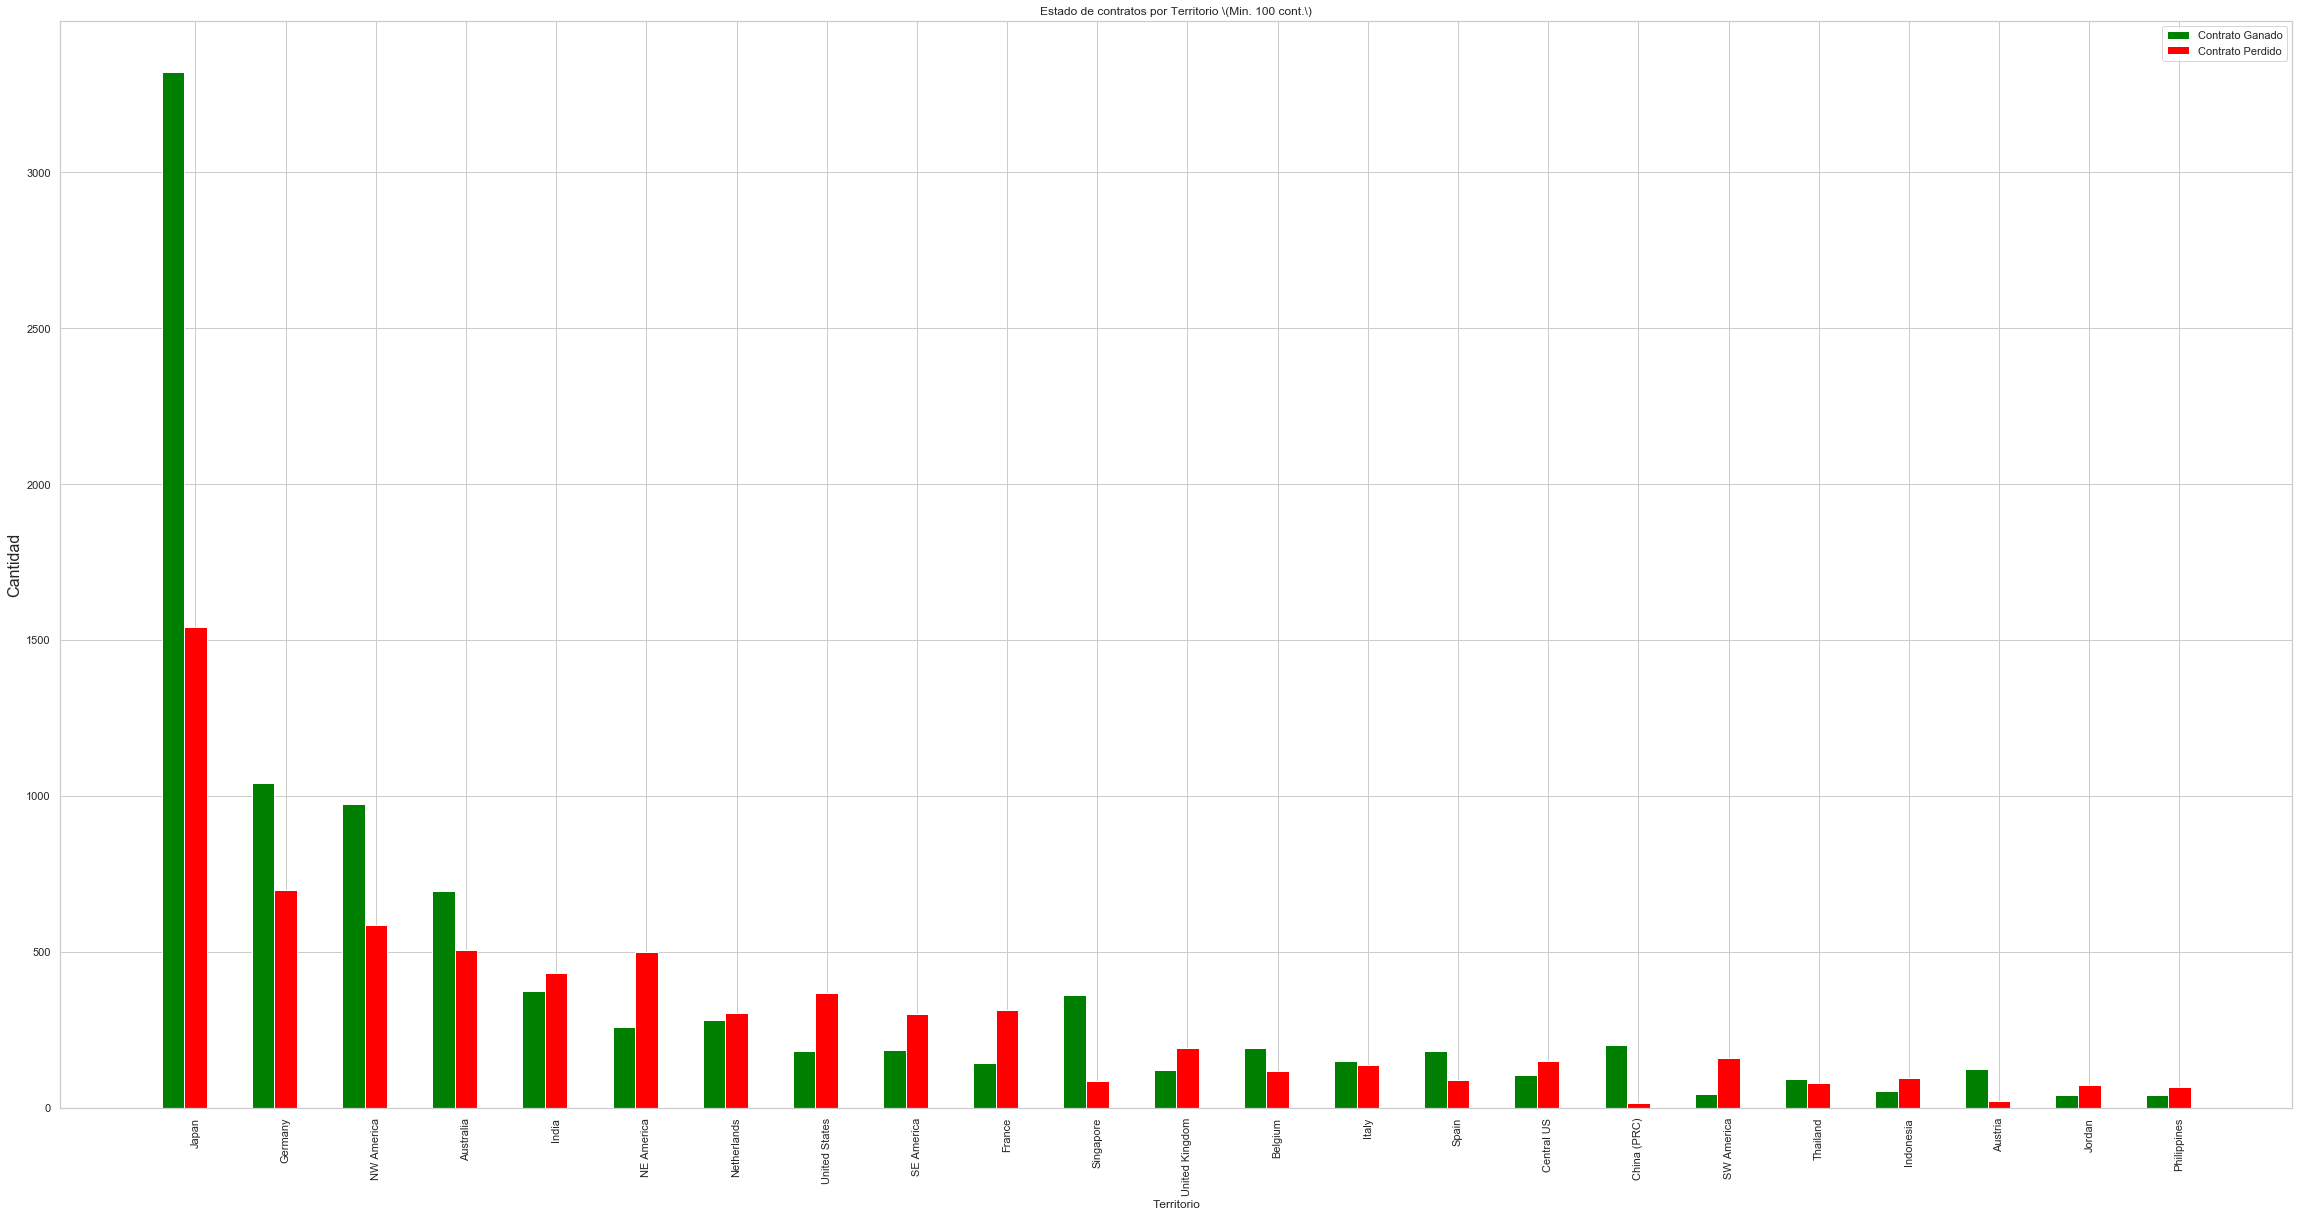

In [26]:
# bar graphs
fig, ax = plt.subplots()
x = np.arange(territories_gt_100_contracts.shape[0])
width = 0.25

c_won = territories_gt_100_contracts["Closed Won"].to_numpy()
c_lost = territories_gt_100_contracts["Closed Lost"].to_numpy()

ax.bar(x, c_won, width, color='green', label='Contrato Ganado')
ax.bar(x + width, c_lost , width, color='red', label='Contrato Perdido')
ax.set_xticks(x + width)
ax.set_xticklabels(territories_gt_100_contracts['Territory'], rotation='vertical')
plt.title("Estado de contratos por Territorio \(Min. 100 cont.\)")
plt.xlabel("Territorio", fontsize='large')
plt.ylabel("Cantidad", fontsize=16)
ax.legend()
plt.rcParams['figure.figsize'] = [40, 15]
plt.show()